In [124]:
import imageio
from matplotlib import pyplot as plt
import random
import numpy as np

In [147]:
#data = imageio.imread('data/bird_small.png')
data = imageio.imread('data/cat_small.jpg')
print(data.shape)
data

(384, 288, 3)


Array([[[ 46,  21,  16],
        [ 46,  21,  16],
        [ 44,  21,  13],
        ...,
        [ 10,   6,   3],
        [ 11,   7,   4],
        [ 10,   6,   3]],

       [[ 44,  21,  13],
        [ 46,  23,  15],
        [ 44,  21,  13],
        ...,
        [ 10,   6,   3],
        [ 11,   7,   4],
        [ 10,   6,   3]],

       [[ 47,  24,  16],
        [ 47,  24,  16],
        [ 45,  22,  14],
        ...,
        [ 10,   6,   3],
        [ 11,   7,   4],
        [  9,   5,   2]],

       ...,

       [[ 23,  17,  19],
        [ 22,  16,  18],
        [ 23,  17,  19],
        ...,
        [149, 120, 102],
        [150, 121, 103],
        [148, 119, 101]],

       [[ 21,  17,  18],
        [ 21,  17,  18],
        [ 22,  16,  18],
        ...,
        [148, 119, 103],
        [148, 119, 103],
        [148, 119, 103]],

       [[ 22,  16,  18],
        [ 24,  18,  20],
        [ 22,  16,  18],
        ...,
        [147, 118, 102],
        [146, 117, 101],
        [149, 120, 104]]

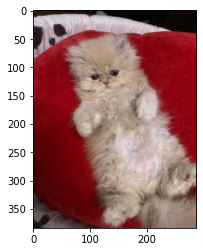

In [148]:
plt.imshow(data)

In [149]:
def find_nearest_cluster(data, index, mus):
    result = None
    result_cost = None
    at = data[index[0], index[1]]
    at0 = float(at[0])
    at1 = float(at[1])
    at2 = float(at[2])

    for idx in range(0, len(mus)):
        mu = mus[idx]
        dx = float(mu[0]) - at0
        dy = float(mu[1]) - at1
        dz = float(mu[2]) - at2
        cost = (dx*dx) + (dy*dy) + (dz * dz)
        if result_cost is None or (cost - result_cost) < -1e-5:
            result = idx
            result_cost = cost

    return result, result_cost

def assign_cluster(data, mus):
    xs = data.shape[0]
    ys = data.shape[1]
    result = []
    result_cost = 0
    
    for x in range(0, xs):
        result_row = []
        for y in range(0, ys):
            c, cost = find_nearest_cluster(data, [x, y], mus)
            result_row.append(c)
            result_cost = result_cost + cost
        result.append(result_row)

    return result, result_cost / (xs * ys)

def select_mus(data, c, mus, num_clusters):
    cluster_sum = [None] * num_clusters
    cluster_count = [0] * num_clusters
    xs = data.shape[0]
    ys = data.shape[1]
    
    for x in range(0, xs):
        for y in range(0, ys):
            selected_c = c[x][y]
            cluster_count[selected_c] = cluster_count[selected_c] + 1
            if cluster_sum[selected_c] is None:
                cluster_sum[selected_c] = np.array(data[x, y], np.uint64)
            else:
                cluster_sum[selected_c] = cluster_sum[selected_c] + np.array(data[x, y], np.uint64)

    result = []
    for i in range(0, num_clusters):
        if cluster_count[i] == 0:
            result.append(mus[i])
        else:
            result.append(np.array(np.floor(cluster_sum[i] / cluster_count[i]), np.uint8))
        
    return result, True

def iteration(data, mus):
    c, cost = assign_cluster(data, mus)
    mus, ok = select_mus(data, c, mus, len(mus))
    return c, mus, cost, ok

def pick_initial_mus(data, num_clusters):
    result = []
    for i in range(0, num_clusters):
        result.append(np.array([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)], np.uint8))
    return result

def solve_once(data, num_clusters, retry, sensitivity):
    c = None
    best_cost = None
    best_c = None
    try_count = 0
    
    mus = pick_initial_mus(data, num_clusters)
    
    while try_count <= retry:
        print('?? solver:', try_count, '/', retry)
        try_count = try_count + 1
        c, mus, cost, ok = iteration(data, mus)
        if not ok:
            return None, None, None, False
        if best_cost is None:
            best_cost = cost
            best_c = c
            try_count = 1
        else:
            if abs(best_cost - cost) < sensitivity:
                return best_c, best_cost, mus, True
            if cost - best_cost < sensitivity:
                print('solver diff', best_cost - cost)
                best_cost = cost
                best_c = c
                try_count = 1
                
    if best_cost is None:
        return None, None, None, False
    return best_c, best_cost, mus, True
                
def solve(data, num_clusters, retry, sensitivity):
    try_count = 0
    best_c = None
    best_cost = None
    best_mus = None
    while try_count <= retry:
        print('? solving using a random seed:', try_count, '/', retry)
        try_count = try_count + 1
        c, cost, mus, ok = solve_once(data, num_clusters, retry, sensitivity)
        if not ok:
            num_clusters = num_clusters - 1
            try_count = 0
            continue
        if best_c is None:
            best_c = c
            best_cost = cost
            best_mus = mus
            try_count = 1
        elif abs(best_cost - cost) >= sensitivity and (cost - best_cost) < sensitivity:
            best_cost = cost
            best_c = c
            best_mus = mus
            try_count = 1
            
    return best_c, best_mus

def compress(data, num_colors):
    c, mus = solve(data, num_colors, 3, 1)
    result = []
    
    xs = data.shape[0]
    ys = data.shape[1]
    for x in range(0, xs):
        result_row = []
        for y in range(0, ys):
            result_row.append(mus[c[x][y]])
        result.append(result_row)
        
    return np.array(result)
    

? solving using a random seed: 0 / 3
?? solver: 0 / 3
?? solver: 1 / 3
solver diff 6884.2210196035885
?? solver: 1 / 3
solver diff 255.09299949363424
?? solver: 1 / 3
solver diff 106.62034324363435
?? solver: 1 / 3
solver diff 37.09818974247685
?? solver: 1 / 3
solver diff 16.720721209490648
?? solver: 1 / 3
solver diff 6.960268373842609
?? solver: 1 / 3
solver diff 3.0108868634259807
?? solver: 1 / 3
solver diff 1.2928783275463047
?? solver: 1 / 3
? solving using a random seed: 1 / 3
?? solver: 0 / 3
?? solver: 1 / 3
solver diff 2595.2121129918983
?? solver: 1 / 3
solver diff 85.88566080729169
?? solver: 1 / 3
solver diff 29.186975549768533
?? solver: 1 / 3
solver diff 31.567952473958314
?? solver: 1 / 3
solver diff 31.53931568287038
?? solver: 1 / 3
solver diff 38.888816550925924
?? solver: 1 / 3
solver diff 27.88566984953701
?? solver: 1 / 3
solver diff 11.050374348958371
?? solver: 1 / 3
solver diff 6.221426504629619
?? solver: 1 / 3
solver diff 5.323269314236114
?? solver: 1 / 3
s

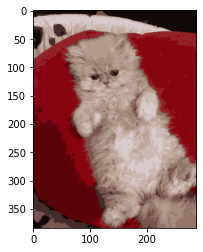

In [150]:
compressed = compress(data, 16)
plt.imshow(compressed)

? solving using a random seed: 0 / 3
?? solver: 0 / 3
?? solver: 1 / 3
solver diff 9815.688033492477
?? solver: 1 / 3
solver diff 162.4644730179399
?? solver: 1 / 3
solver diff 34.43838614004619
?? solver: 1 / 3
solver diff 8.85024233217598
?? solver: 1 / 3
solver diff 2.151638454861086
?? solver: 1 / 3
? solving using a random seed: 1 / 3
?? solver: 0 / 3
?? solver: 1 / 3
solver diff 2795.4439561631943
?? solver: 1 / 3
solver diff 107.310546875
?? solver: 1 / 3
solver diff 38.16131365740739
?? solver: 1 / 3
solver diff 15.656177662036953
?? solver: 1 / 3
solver diff 7.844798900463047
?? solver: 1 / 3
solver diff 6.788420500578695
?? solver: 1 / 3
solver diff 7.055157696759352
?? solver: 1 / 3
solver diff 9.676622178819343
?? solver: 1 / 3
solver diff 27.247088396990762
?? solver: 1 / 3
solver diff 135.68937174479174
?? solver: 1 / 3
solver diff 196.07307038483793
?? solver: 1 / 3
solver diff 53.97920283564815
?? solver: 1 / 3
solver diff 13.909414785879562
?? solver: 1 / 3
solver diff

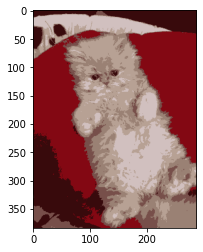

In [151]:
compressed = compress(data, 8)
plt.imshow(compressed)

? solving using a random seed: 0 / 3
?? solver: 0 / 3
?? solver: 1 / 3
solver diff 4588.960810908565
?? solver: 1 / 3
solver diff 162.12992802372673
?? solver: 1 / 3
solver diff 71.11854383680566
?? solver: 1 / 3
solver diff 15.927200882523039
?? solver: 1 / 3
solver diff 6.5384114583332575
?? solver: 1 / 3
solver diff 6.10637297453718
?? solver: 1 / 3
solver diff 20.59663447627304
?? solver: 1 / 3
solver diff 109.36674442997696
?? solver: 1 / 3
solver diff 128.13493742766195
?? solver: 1 / 3
solver diff 38.746048538773266
?? solver: 1 / 3
solver diff 6.749303747106296
?? solver: 1 / 3
solver diff 2.1695963541667425
?? solver: 1 / 3
? solving using a random seed: 1 / 3
?? solver: 0 / 3
?? solver: 1 / 3
solver diff 1844.7141474971063
?? solver: 1 / 3
solver diff 80.72111002604174
?? solver: 1 / 3
solver diff 63.256863064236086
?? solver: 1 / 3
solver diff 47.369674117476734
?? solver: 1 / 3
solver diff 27.38129340277783
?? solver: 1 / 3
solver diff 17.576099537036953
?? solver: 1 / 3
so

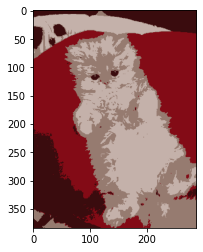

In [152]:
compressed = compress(data, 4)
plt.imshow(compressed)

? solving using a random seed: 0 / 3
?? solver: 0 / 3
?? solver: 1 / 3
solver diff 23578.18798828125
?? solver: 1 / 3
solver diff 1661.4658745659717
?? solver: 1 / 3
solver diff 158.52788628472217
?? solver: 1 / 3
solver diff 6.815049913194798
?? solver: 1 / 3
? solving using a random seed: 1 / 3
?? solver: 0 / 3
?? solver: 1 / 3
solver diff 7160.887496383103
?? solver: 1 / 3
solver diff 3884.793411820023
?? solver: 1 / 3
solver diff 135.8046513310187
?? solver: 1 / 3
solver diff 9.388916015625
?? solver: 1 / 3
solver diff 1.5124782986108585
?? solver: 1 / 3
? solving using a random seed: 2 / 3
?? solver: 0 / 3
?? solver: 1 / 3
solver diff 15422.123625578704
?? solver: 1 / 3
solver diff 1.403899016203468
?? solver: 1 / 3
? solving using a random seed: 3 / 3
?? solver: 0 / 3
?? solver: 1 / 3
solver diff 9460.727376302084
?? solver: 1 / 3
solver diff 2458.6433557581017
?? solver: 1 / 3
solver diff 356.845947265625
?? solver: 1 / 3
solver diff 14.007622612847172
?? solver: 1 / 3


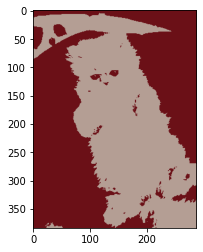

In [153]:
compressed = compress(data, 2)
plt.imshow(compressed)